In [1]:
#!/usr/bin/python

import sys
import pickle
import matplotlib.pyplot
#sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
print 'number of people in data set = ', len(data_dict)
print 'features for every person in the data set:\n', data_dict['LAY KENNETH L'].keys()

C:\Users\nmeli\Documents\Udacity\Data Analysis\Anacondas\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


number of people in data set =  146
features for every person in the data set:
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


In [2]:
### Task 2: Remove outliers
''' as seen in the outliers section, we saw that there was a "Total" entry in the data set that was a clear outlier.
thus we are removing it
'''
data_dict.pop("TOTAL",0)

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [36]:
# EDA for data set. Code to convert data set into a pandas df taken from:
#from post https://discussions.udacity.com/t/pickling-pandas-df/174753
import pandas
# Your code
df = pandas.DataFrame.from_records(list(data_dict.values()))
employees = pandas.Series(list(data_dict.keys()))

# set the index of df to be the employees series:
df.set_index(employees, inplace=True)
                          
df.head()


,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [38]:
# convert strings to numbers and replace NaN with 0
df_calculations = df.apply(pandas.to_numeric, errors='coerce').fillna(0)
df_calculations.head()



,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000.0,0.0,0.0,0.0,0.0,0.0,94299.0,29.0,38.0,1.0,...,0.0,1740.0,False,585062.0,0.0,365788.0,702.0,807.0,1061827.0,585062.0
BAXTER JOHN C,1200000.0,1295738.0,-1386055.0,0.0,0.0,6680544.0,11200.0,0.0,0.0,0.0,...,1586055.0,2660303.0,False,3942714.0,0.0,267102.0,0.0,0.0,5634343.0,10623258.0
ELLIOTT STEVEN,350000.0,0.0,-400729.0,0.0,0.0,4890344.0,78552.0,0.0,0.0,0.0,...,0.0,12961.0,False,1788391.0,0.0,170941.0,0.0,0.0,211725.0,6678735.0
CORDES WILLIAM R,0.0,0.0,0.0,0.0,0.0,651850.0,0.0,12.0,10.0,0.0,...,0.0,0.0,False,386335.0,0.0,0.0,58.0,764.0,0.0,1038185.0
HANNON KEVIN P,1500000.0,0.0,-3117011.0,0.0,0.0,5538001.0,34039.0,32.0,32.0,21.0,...,1617011.0,11350.0,True,853064.0,0.0,243293.0,1035.0,1045.0,288682.0,6391065.0


In [53]:
### Task 3: Create new feature(s)


### Store to my_dataset for easy export below.
my_dataset = data_dict


features for every person in the data set:
{'to_messages': 4273, 'deferral_payments': 202911, 'expenses': 99832, 'total_poi_emails': 2657, 'poi': True, 'deferred_income': -300000, 'email_address': 'kenneth.lay@enron.com', 'long_term_incentive': 3600000, 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 2411, 'loan_advances': 81525000, 'from_messages': 36, 'other': 10359729, 'director_fees': 'NaN', 'bonus': 7000000, 'total_stock_value': 49110078, 'from_poi_to_this_person': 123, 'from_this_person_to_poi': 16, 'restricted_stock': 14761694, 'salary': 1072321, 'total_payments': 103559793, 'exercised_stock_options': 34348384}


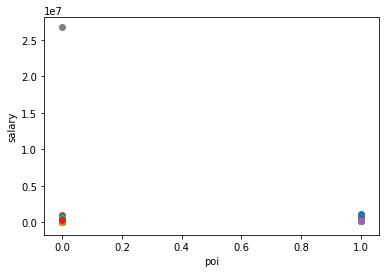

In [20]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [ ]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html




In [ ]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)